In [16]:
%load_ext autoreload
%autoreload 2

# Setup Environment
import sys
import os
ROOT = '../../'
sys.path.append(ROOT)

from pettingzoo.classic import tictactoe_v3
import numpy as np
import copy
from gym.wrappers.monitoring.video_recorder import VideoRecorder
from IPython.display import HTML
from source.agents.dqn_agent import DQNAgent
from source.agents.advantage_actor_critic_agent import A2CAgent
from source.agents.ppo_agent import PPOAgent
from source.agents.random_agent import RandomAgent
from source.utils import utils
from tqdm import tqdm
import torch
import random
from typing import Dict, Optional, Tuple
from collections import defaultdict
from source.agents.agent import Agent
from pettingzoo.utils.env import AECEnv

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


using device: cpu
[128]
using device: cpu
using device: cpu
agents: {'player_1': <source.agents.ppo_agent.PPOAgent object at 0x17176b700>, 'player_2': <source.agents.ppo_agent.PPOAgent object at 0x29510a070>}


100%|██████████| 1000/1000 [00:11<00:00, 85.20it/s]


epoch: 0, reward: 0.01300, win: 447, lose: 434, draw: 119, episode_len: 4.75400, value_loss: 0.27913, policy_loss: -0.10058, clip_loss: -0.10058, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:11<00:00, 85.45it/s]


epoch: 1, reward: -0.02100, win: 435, lose: 456, draw: 109, episode_len: 4.70700, value_loss: 0.27876, policy_loss: -0.09471, clip_loss: -0.09471, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:11<00:00, 85.59it/s]


epoch: 2, reward: -0.03700, win: 433, lose: 470, draw: 97, episode_len: 4.62300, value_loss: 0.27675, policy_loss: -0.07329, clip_loss: -0.07329, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:11<00:00, 87.95it/s]


epoch: 3, reward: 0.01800, win: 473, lose: 455, draw: 72, episode_len: 4.53300, value_loss: 0.29676, policy_loss: -0.07329, clip_loss: -0.07329, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:10<00:00, 93.00it/s]


epoch: 4, reward: -0.01200, win: 458, lose: 470, draw: 72, episode_len: 4.44600, value_loss: 0.29852, policy_loss: -0.03624, clip_loss: -0.03624, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:11<00:00, 90.17it/s]


epoch: 5, reward: -0.03300, win: 461, lose: 494, draw: 45, episode_len: 4.31400, value_loss: 0.27005, policy_loss: -0.05429, clip_loss: -0.05429, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:10<00:00, 95.29it/s]


epoch: 6, reward: -0.04300, win: 467, lose: 510, draw: 23, episode_len: 4.27000, value_loss: 0.22032, policy_loss: -0.02412, clip_loss: -0.02412, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:09<00:00, 101.79it/s]


epoch: 7, reward: 0.01300, win: 499, lose: 486, draw: 15, episode_len: 4.11900, value_loss: 0.16279, policy_loss: -0.02136, clip_loss: -0.02136, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:09<00:00, 103.32it/s]


epoch: 8, reward: 0.02000, win: 506, lose: 486, draw: 8, episode_len: 4.02800, value_loss: 0.12128, policy_loss: -0.02520, clip_loss: -0.02520, entropy: 0.00000, num_policy_udpate: 2.00000, 


100%|██████████| 1000/1000 [00:09<00:00, 101.61it/s]


epoch: 9, reward: 0.03800, win: 516, lose: 478, draw: 6, episode_len: 4.00600, value_loss: 0.11573, policy_loss: -0.00174, clip_loss: -0.00174, entropy: 0.00000, num_policy_udpate: 2.00000, 


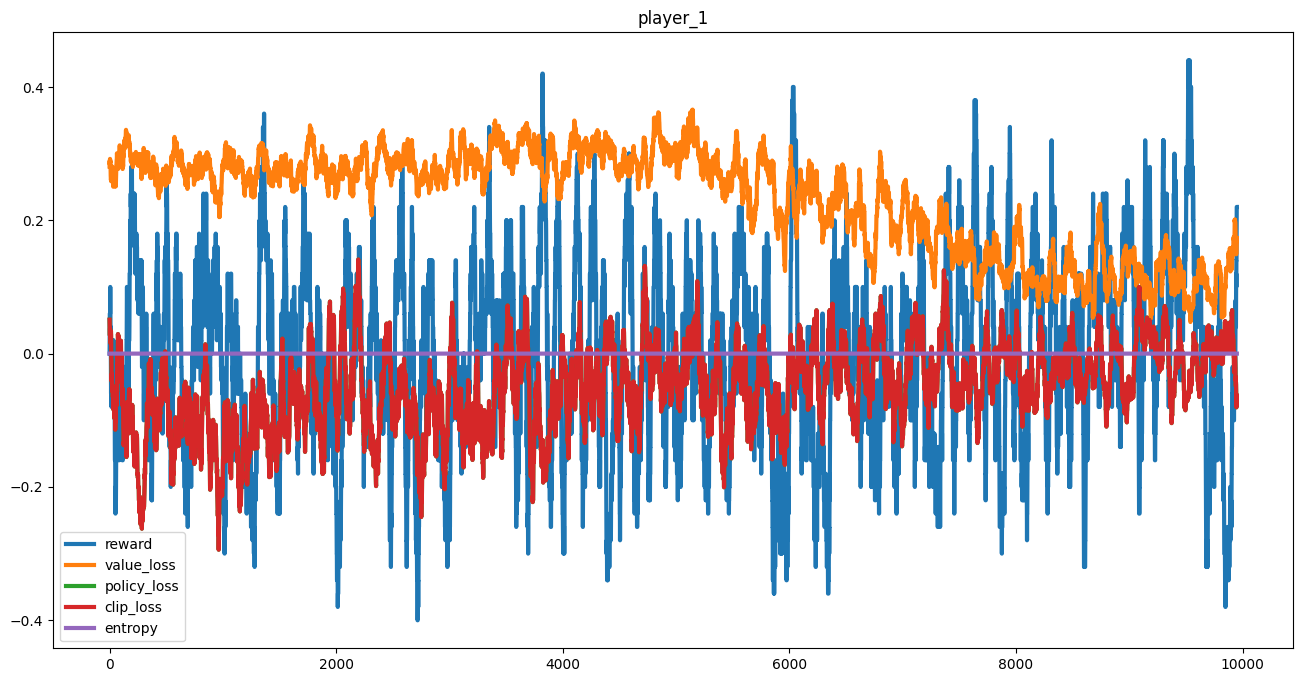

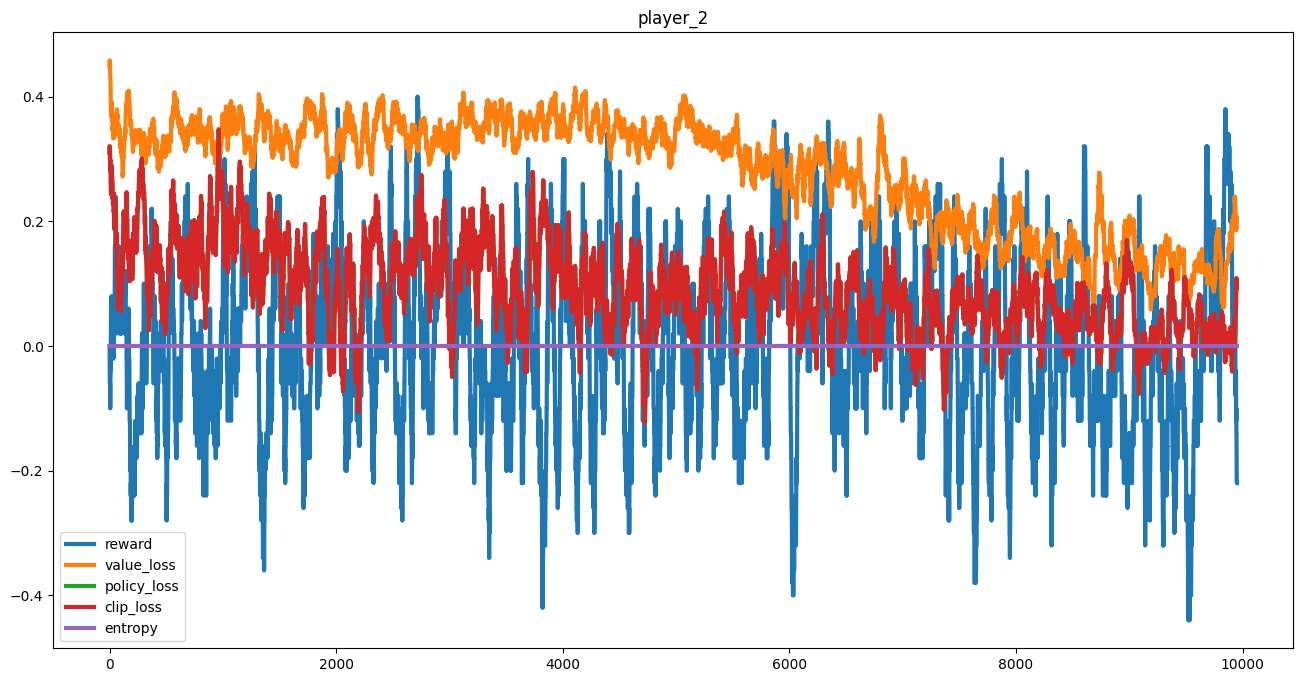

In [17]:
# Policy Eval
# Params
env = tictactoe_v3.env()

# set random seeds
random_seed = 101
rng = np.random.default_rng(random_seed)
env.np_random = rng
#random.seed(random_seed)
#torch.manual_seed(random_seed)

# Create Environment.
#env = gym.make('Taxi-v3')
# using render_mode=rgb_array so that video recording works
#env = gym.make(
#    "LunarLander-v2",
#    render_mode='rgb_array'
#)
#env = gym.make("CarRacing-v2", render_mode='rgb_array', continuous=False)
#env = gym.make("CartPole-v1", render_mode='rgb_array')


# Create Agent
## Best performance (dqn, random): 0 loss in 1000, eps_decay=1e7
## Best performance (dqn, dqn): 1000 draw in 1000, eps_decay=1e8
dqn_agent = DQNAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=0.9, # use epsilon_schedule
    learning_rate=1e-3,
    learning=True,
    batch_size = 64,
    tau = 0.005,
    eps_decay=1e7, #1e7 for (dqn, random), 1e8 for (dqn, dqn)
    net_params=[128],
    update_freq=1
)
## Best performance (a2c, random): ~50 loss in 1000, discount=0.5, width=256
## 
a2c_agent = A2CAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=1e-3,
    value_lr=1e-3,
    net_params=[256], #128 perform best with temp = 1
    tempreture=1
)
ppo_agent = PPOAgent(
    state_space=env.observation_space('player_1')['observation'],
    action_space=env.action_space('player_1'),
    discount_rate=0.5,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    policy_lr=3e-4, #spinup default=3e-4
    value_lr=1e-3, #spinup default=1e-3
    net_params=[16],
    gae_lambda=0.97, #spinup default=0.97
    clip_ratio=0.1, #spinup default=0.1
    num_updates=2, #spinup default=80
    entropy_coeff=0.0,
)
random_agent = RandomAgent(    
    state_space=env.observation_space('player_2')['observation'],
    action_space=env.action_space('player_2'),
    discount_rate=None,
    epsilon=None, # use epsilon_schedule
    learning_rate=None,
    learning=False
)
logging = utils.duel_training(
    env=env, 
    agent_dict={'player_1': ppo_agent}, 
    num_epoch=50, 
    num_episode=1000, 
    self_play=True, 
    shuffle=True, 
    verbal=True
)
utils.plot_training_logs(logging)

In [18]:
env = tictactoe_v3.env(render_mode='human')
utils.play_multiagent_episode({'player_1': ppo_agent, 'player_2': ppo_agent}, env, shuffle=False,debug=False)
#html=utils.render_mp4(video_path)
#HTML(html)


     |     |     
  -  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  O  |  -  |  -  
_____|_____|_____
     |     |     
  -  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  O  |  -  |  -  
_____|_____|_____
     |     |     
  X  |  X  |  -  
_____|_____|_____
     |     |     
  -  |  -  |  -  
     |     |     
     |     |     
  O  |  -  |  -  
_____|_____|_____
     |     |     
  X  |  X  |  -  
_____|_____|_____
     |     |     
  O  |  -  |  -  
     |     |     
     |     |     
  O  |  -  |  -  
_____|_____|_____
     |     |     
  X  |  X  |  X  
_____|_____|_____
     |     |     
  O  |  -  |  -  
     |     |     


RuntimeError: torch.cat(): expected a non-empty list of Tensors